# Code crop da bo sung them skip in black list, doi voi truong hop cac phien hieu giua S2, S1 khong khop ve kich thuoc
# Hien tai dang co 20 phien hieu khong khop kich thuoc

In [ ]:
import os
# import glob
# import argparse
import numpy as np
import rasterio
from PIL import Image
from rasterio.transform import from_bounds
from tqdm import tqdm
# import skimage.io
import yaml
import sys
# __dir__ = os.path.dirname(os.path.abspath(__file__))
# sys.path.append(__dir__)
# sys.path.insert(0, os.path.abspath(os.path.join(__dir__, '../../')))

# from ssr.utils.options import yaml_load
import shutil

import random
from rasterio.windows import Window
from collections import OrderedDict


def load_black_list(black_list_path) -> list:
    black_list = []
    try:
        with open(black_list_path, 'r') as file:
            for line in file.readlines():
                black_list.append(os.path.basename(line.strip()).split('.')[0])
        return black_list
    
    except FileNotFoundError as e:
        print(f'{e}: Black list path isnt valid')
        sys.exit(1)


def load_whitelist(whitelist_path) -> list:
    """Load whitelist of file names from a txt file.
    
    Args:
        whitelist_path (str): Path to the whitelist file
        
    Returns:
        list: List of file names (without extension) from whitelist
    """
    whitelist = []
    try:
        with open(whitelist_path, 'r') as file:
            for line in file.readlines():
                line = line.strip()
                if line:  # Skip empty lines
                    whitelist.append(os.path.basename(line).split('.')[0])
        return whitelist
    except FileNotFoundError as e:
        print(f'{e}: Whitelist path isnt valid')
        sys.exit(1)


def in_black_list(filename ,black_list):
    for fn in black_list:
        if fn == filename:
            return True
    return False


def in_whitelist(filename, whitelist):
    """Check if filename is in whitelist.
    
    Args:
        filename (str): File name to check (without extension)
        whitelist (list): List of whitelisted file names
        
    Returns:
        bool: True if filename is in whitelist, False otherwise
    """
    for fn in whitelist:
        if fn == filename:
            return True
    return False


def db2linear(image_data, v_min = -25, v_max = 5):
    data_clipped = np.clip(image_data, v_min, v_max)
    data_norm = (data_clipped-v_min)/(v_max-v_min)
    data_uint8 = (data_norm * 255).astype(np.uint8)
    return data_uint8


def change_range_f(image_data, old_min, old_max, new_min, new_max):
    new_image = ((image_data-old_min) * (new_max - new_min) / (old_max - old_min) + new_min).clip(new_min, new_max)
    new_image = (new_image - new_min) / (new_max - new_min)
    new_image = (new_image * 255).astype(np.uint8)
    return new_image



def ordered_yaml():
    """Support OrderedDict for yaml.

    Returns:
        tuple: yaml Loader and Dumper.
    """
    try:
        from yaml import CDumper as Dumper
        from yaml import CLoader as Loader
    except ImportError:
        from yaml import Dumper, Loader

    _mapping_tag = yaml.resolver.BaseResolver.DEFAULT_MAPPING_TAG

    def dict_representer(dumper, data):
        return dumper.represent_dict(data.items())

    def dict_constructor(loader, node):
        return OrderedDict(loader.construct_pairs(node))

    Dumper.add_representer(OrderedDict, dict_representer)
    Loader.add_constructor(_mapping_tag, dict_constructor)
    return Loader, Dumper


def yaml_load(f):
    """Load yaml file or string.

    Args:
        f (str): File path or a python string.

    Returns:
        dict: Loaded dict.
    """
    if os.path.isfile(f):
        with open(f, 'r') as f:
            return yaml.load(f, Loader=ordered_yaml()[0])
    else:
        return yaml.load(f, Loader=ordered_yaml()[0])


def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

num_cols = None
num_rows = None
height = None
width = None


def split_and_save_image_with_overlap_change(image_path, output_dir, 
                                             tile_size = 32,
                                               split_factor: int = 2,
                                                 remove_A:int = 1,
                                              db2ln: bool = False,
                                                sar_vv: bool = False,
                                                  sar_vh: bool = False,
                                                    change_range:bool = False,
                                                downsample: int = 0,
                                                  four_bands:bool = False,
                                                  save_fmt: str = 'TIFF'):
    old_min = -25
    old_max = 0
    new_min = -25
    new_max = 5

    def process_and_save(tile, row, col):
        if db2ln: # convert [-25db, 0db] -> [0, 255] (Thuc te la 0-5000 -> 0-255 cho S2)
            if sar_vv:
                tile = db2linear(tile[:, :, 0])
            elif sar_vh:
                tile = db2linear(tile[:, :, 1])
            else:
                tile = db2linear(tile[:, :, :])
        
        if change_range:
            if sar_vv:
                tile = change_range_f(tile[:, :, 0], old_min = old_min, old_max = old_max, new_min = new_min, new_max = new_max)
            elif sar_vh:
                tile = change_range_f(tile[:, :, 1],  old_min = old_min, old_max = old_max, new_min = new_min, new_max = new_max)

        tile_img = Image.fromarray(tile)

        if downsample:
            tile_img = tile_img.resize(size = (tile_size//downsample, tile_size//downsample), resample=Image.Resampling.BICUBIC)
        
        ext = '.png' if save_fmt.lower() == 'png' else '.tif'
        tile_path = os.path.join(output_dir, f"{row}_{col}_{os.path.splitext(os.path.basename(image_path))[0]}{ext}")
        tile_img.save(tile_path, format=save_fmt)

    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform
        width, height = src.width, src.height
        array = np.array(image)

        # print(f'Shape of {os.path.basename(image_path)}: {array.shape}') # HERE
        if array.shape[1] < tile_size or array.shape[2] < tile_size:
            print(f'Shape of image must not smaller than {tile_size}. NEXT!')
            return
    image = np.transpose(image, (1, 2, 0))
    # print(image.shape) # debug
    if remove_A:
        image = image[:, :, 0:3]

    # tile_size = 32
    # print(height, tile_size, split_factor)
    num_rows = height // int(tile_size  / split_factor)
    num_cols = width // int(tile_size  / split_factor)
    # print("num rows:, num col",num_rows,num_cols)
    # input()
    for row in range(num_rows):
        for col in range(num_cols):
            start_row = row*(tile_size//split_factor)
            end_row = row*(tile_size//split_factor) + tile_size
            start_col = col*(tile_size//split_factor)
            end_col = col*(tile_size//split_factor) + tile_size

            if end_row <= height and end_col <= width:
            # print(f'1: [{row*(tile_size//split_factor)}:{row*(tile_size//split_factor) + tile_size}, {col*(tile_size//split_factor)} : {(col)*(tile_size//split_factor) + tile_size}, :]')
                tile = image[start_row: end_row, start_col: end_col, :]
                process_and_save(tile, row, col)

    # row = num_rows - 1 # HERE
    # col = num_cols - 1 # HERE

    if height % tile_size != 0:
        # row = num_rows
        for col in range(num_cols):
            start_row = height - tile_size
            start_col = col*(tile_size//split_factor)
            end_col = col*(tile_size//split_factor) + tile_size

            if end_col <= width:
              
                # print(f'2: [{start_row}:{height}, {col*(tile_size//split_factor)} : {(col)*(tile_size//split_factor) + tile_size}, :]')

                tile = image[start_row:, start_col:end_col, :]
                process_and_save(tile, row, col)

    if width % tile_size != 0:
        # col = num_cols
        for row in range(num_rows):
            start_col = width - tile_size
            start_row = row * (tile_size // split_factor)
            end_row = row * (tile_size // split_factor) + tile_size

            # print(f'3: [{start_col}:{width}, {row*(tile_size//split_factor)} : {(row)*(tile_size//split_factor) + tile_size}, :]')
            if end_row <= height:
                
                tile = image[start_row : end_row, start_col:, :]
                process_and_save(tile, row, col)


    if height % tile_size != 0 and width % tile_size != 0:
        start_row = height - tile_size
        start_col = width - tile_size
        # row = num_rows
        # col = num_cols
        tile = image[start_row:, start_col:, :]
        process_and_save(tile, row, col)


if __name__ == "__main__":
    # Load configuration file
    # parser = argparse.ArgumentParser()
    # parser.add_argument('-opt', type=str, default= '/mnt/data1tb/vinh/ISSM-SAR/utils/config_crop_s2_lc_s1.yaml', help="Path to the options file.")
    # parser.add_argument('-remove_A', type=int, required=True)
    # args = parser.parse_args()

    # opt = yaml_load(args.opt)
    config_path = '/mnt/data1tb/vinh/ISSM-SAR/utils/config_crop_s2_lc_s1.yaml'
    opt = yaml_load(config_path)
    # number_of_random_img = opt['number_of_random_img'] # HERE
    chip_size = opt['chip_size']
    data_dir = opt['data_dir']
    split_dir = opt['split_dir']
    split_factor = opt['split_factor']
    remove_A = opt['remove_A']
    db2ln = opt['db2ln']
    sar_vv = opt['sar_vv']
    sar_vh = opt['sar_vh']
    change_range = opt['change_range']
    downsample = opt['downsample']
    four_bands = opt['four_bands']
    save_fmt = opt.get('save_fmt', 'TIFF')
    black_list_path = opt['black_list_path']
    whitelist_path = opt['white_list_path']  # Optional whitelist

    black_list = load_black_list(black_list_path)
    print(f'Loaded {len(black_list)} items in blacklist')
    
    whitelist = None
    if whitelist_path and os.path.exists(whitelist_path):
        whitelist = load_whitelist(whitelist_path)
        print(f'Loaded {len(whitelist)} items in whitelist from {whitelist_path}')
    else:
        print('No whitelist provided - will process all files (except blacklisted)')
    
    count_in_black_list = 0
    count_not_in_whitelist = 0
    count_processed = 0
    
    # file_name_except = opt['file_name_except']
    # List of tiff files in Dir S2 LR
    tiff_files = [f for f in os.listdir(data_dir) if f.endswith('.tif')]
    print(f'Found {len(tiff_files)} .tif files in {data_dir}')
    
    if remove_A:
        print('Remove A channels of LandCover')
    
    for tiff_file in tqdm(tiff_files, desc=f"Splitting to {chip_size}x{chip_size} tiles"):
        filename_without_ext = tiff_file.split('.')[0]
        
        # Check blacklist
        if in_black_list(filename_without_ext, black_list):
            print(f'SKIP - Blacklisted: {tiff_file}')
            count_in_black_list += 1
            continue
        
        # Check whitelist
        if whitelist is not None:
            if not in_whitelist(filename_without_ext, whitelist):
                print(f'SKIP - Not in whitelist: {tiff_file}')
                count_not_in_whitelist += 1
                continue
        
        # print("Processing tile: ", tiff_file)
        tiff_path = os.path.join(data_dir, tiff_file)
        output_folder = os.path.join(split_dir)
        ensure_dir(output_folder)

        print(f'Processing: {tiff_file}')
        split_and_save_image_with_overlap_change(tiff_path, output_folder, chip_size, 
                                                 split_factor, remove_A, 
                                                 db2ln, sar_vv, sar_vh, change_range, 
                                                 downsample, four_bands, save_fmt)
        count_processed += 1
    
    print('='*50)
    print('Processing Summary:')
    print(f'Total files found: {len(tiff_files)}')
    print(f'Files processed: {count_processed}')
    print(f'Files in blacklist (skipped): {count_in_black_list}')
    if whitelist is not None:
        print(f'Files not in whitelist (skipped): {count_not_in_whitelist}')
    print(f'Total output files: {len(os.listdir(split_dir))}')
    print('='*50)


# CROP SAR, SAVE DUOI DANG NPY [-1, 1]


In [ ]:
"""
Module for cropping and saving raw SAR data as .npy files.
- Clip values to [-25, 5] dB range
- Normalize to [-1, 1] range
- Save as .npy with filename format: row_col_originalfilename.npy
"""

import os
import numpy as np
import rasterio
from tqdm import tqdm
import yaml
from collections import OrderedDict


def ordered_yaml():
    """Support OrderedDict for yaml.

    Returns:
        tuple: yaml Loader and Dumper.
    """
    try:
        from yaml import CDumper as Dumper
        from yaml import CLoader as Loader
    except ImportError:
        from yaml import Dumper, Loader

    _mapping_tag = yaml.resolver.BaseResolver.DEFAULT_MAPPING_TAG

    def dict_representer(dumper, data):
        return dumper.represent_dict(data.items())

    def dict_constructor(loader, node):
        return OrderedDict(loader.construct_pairs(node))

    Dumper.add_representer(OrderedDict, dict_representer)
    Loader.add_constructor(_mapping_tag, dict_constructor)
    return Loader, Dumper


def yaml_load(f):
    """Load yaml file or string."""
    if os.path.isfile(f):
        with open(f, 'r') as file:
            return yaml.load(file, Loader=ordered_yaml()[0])
    else:
        return yaml.load(f, Loader=ordered_yaml()[0])


def load_black_list(black_list_path) -> list:
    """Load blacklist of file names from a txt file."""
    black_list = []
    try:
        with open(black_list_path, 'r') as file:
            for line in file.readlines():
                black_list.append(os.path.basename(line.strip()).split('.')[0])
        return black_list
    except FileNotFoundError as e:
        print(f'{e}: Black list path isnt valid')
        return []


def load_whitelist(whitelist_path) -> list:
    """Load whitelist of file names from a txt file."""
    whitelist = []
    try:
        with open(whitelist_path, 'r') as file:
            for line in file.readlines():
                line = line.strip()
                if line:
                    whitelist.append(os.path.basename(line).split('.')[0])
        return whitelist
    except FileNotFoundError as e:
        print(f'{e}: Whitelist path isnt valid')
        return []


def in_black_list(filename, black_list):
    return filename in black_list


def in_whitelist(filename, whitelist):
    return filename in whitelist


def clip_and_normalize_to_minus1_1(data, v_min=-25, v_max=5):
    """
    Clip data to [v_min, v_max] then normalize to [-1, 1] range.
    
    Args:
        data: Input numpy array (SAR data in dB)
        v_min: Minimum clip value (default: -25 dB)
        v_max: Maximum clip value (default: 5 dB)
    
    Returns:
        Normalized numpy array in range [-1, 1] as float32
    """
    data_clipped = np.clip(data, v_min, v_max)
    # Normalize to [0, 1] first
    data_norm = (data_clipped - v_min) / (v_max - v_min)
    # Convert to [-1, 1]
    data_normalized = data_norm * 2 - 1
    return data_normalized.astype(np.float32)


def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


def split_and_save_raw_npy(image_path, output_dir, 
                           tile_size=128,
                           split_factor=4,
                           remove_A=False,
                           sar_vv=True,
                           sar_vh=False,
                           v_min=-25,
                           v_max=5,
                           save_fmt='npy'):
    """
    Split image into tiles, clip to [v_min, v_max], normalize to [-1, 1], 
    and save as .npy or .npz files.
    
    Args:
        image_path: Path to input TIFF file
        output_dir: Output directory for saved files
        tile_size: Size of each tile (default: 128)
        split_factor: Overlap factor for splitting (default: 4)
        remove_A: Whether to remove alpha channel (default: False)
        sar_vv: Use only VV band (default: True)
        sar_vh: Use only VH band (default: False)
        v_min: Minimum clip value (default: -25 dB)
        v_max: Maximum clip value (default: 5 dB)
        save_fmt: Save format - 'npy' or 'npz' (default: 'npy')
    """
    
    def process_and_save_raw(tile, row, col):
        # Clip and normalize to [-1, 1]
        tile_normalized = clip_and_normalize_to_minus1_1(tile, v_min, v_max)
        
        # Generate filename: row_col_originalfilename.npy
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        ext = '.npy' if save_fmt.lower() == 'npy' else '.npz'
        tile_path = os.path.join(output_dir, f"{row}_{col}_{base_name}{ext}")
        
        if save_fmt.lower() == 'npy':
            np.save(tile_path, tile_normalized)
        else:
            np.savez_compressed(tile_path, data=tile_normalized)

    with rasterio.open(image_path) as src:
        image = src.read()
        width, height = src.width, src.height
        array = np.array(image)

        if array.shape[1] < tile_size or array.shape[2] < tile_size:
            print(f'Shape of image must not smaller than {tile_size}. NEXT!')
            return 0
    
    image = np.transpose(image, (1, 2, 0))  # (C, H, W) -> (H, W, C)
    
    if remove_A and image.shape[2] > 3:
        image = image[:, :, 0:3]

    # Select channel based on sar_vv or sar_vh
    if sar_vv:
        image = image[:, :, 0:1]  # VV only, keep dims
    elif sar_vh:
        image = image[:, :, 1:2]  # VH only, keep dims

    num_rows = height // int(tile_size / split_factor)
    num_cols = width // int(tile_size / split_factor)
    
    tile_count = 0
    
    # Process main grid
    for row in range(num_rows):
        for col in range(num_cols):
            start_row = row * (tile_size // split_factor)
            end_row = row * (tile_size // split_factor) + tile_size
            start_col = col * (tile_size // split_factor)
            end_col = col * (tile_size // split_factor) + tile_size

            if end_row <= height and end_col <= width:
                tile = image[start_row:end_row, start_col:end_col, :]
                process_and_save_raw(tile, row, col)
                tile_count += 1

    # Handle remaining rows (bottom edge)
    if height % tile_size != 0:
        for col in range(num_cols):
            start_row = height - tile_size
            start_col = col * (tile_size // split_factor)
            end_col = col * (tile_size // split_factor) + tile_size

            if end_col <= width:
                tile = image[start_row:, start_col:end_col, :]
                process_and_save_raw(tile, row, col)
                tile_count += 1

    # Handle remaining columns (right edge)
    if width % tile_size != 0:
        for row in range(num_rows):
            start_col = width - tile_size
            start_row = row * (tile_size // split_factor)
            end_row = row * (tile_size // split_factor) + tile_size

            if end_row <= height:
                tile = image[start_row:end_row, start_col:, :]
                process_and_save_raw(tile, row, col)
                tile_count += 1

    # Handle corner (bottom-right)
    if height % tile_size != 0 and width % tile_size != 0:
        start_row = height - tile_size
        start_col = width - tile_size
        tile = image[start_row:, start_col:, :]
        process_and_save_raw(tile, row, col)
        tile_count += 1
    
    return tile_count


def main(config_path):
    """
    Main function to process all TIFF files based on config.
    
    Args:
        config_path: Path to YAML config file
    """
    opt = yaml_load(config_path)
    
    chip_size = opt.get('chip_size', 128)
    data_dir = opt['data_dir']
    split_dir = opt.get('split_dir_raw')  # Default: add _raw suffix
    split_factor = opt.get('split_factor', 4)
    remove_A = opt.get('remove_A', False)
    sar_vv = opt.get('sar_vv', True)
    sar_vh = opt.get('sar_vh', False)
    v_min = opt.get('v_min', -25)
    v_max = opt.get('v_max', 5)
    save_fmt = opt.get('raw_save_fmt', 'npy')
    black_list_path = opt.get('black_list_path', '')
    whitelist_path = opt.get('white_list_path', '')

    # Load blacklist and whitelist
    black_list = load_black_list(black_list_path) if black_list_path else []
    if black_list:
        print(f'Loaded {len(black_list)} items in blacklist')
    
    whitelist = None
    if whitelist_path and os.path.exists(whitelist_path):
        whitelist = load_whitelist(whitelist_path)
        print(f'Loaded {len(whitelist)} items in whitelist from {whitelist_path}')
    else:
        print('No whitelist provided - will process all files (except blacklisted)')
    
    count_in_black_list = 0
    count_not_in_whitelist = 0
    count_processed = 0
    total_tiles = 0
    
    # List TIFF files
    tiff_files = [f for f in os.listdir(data_dir) if f.endswith('.tif')]
    print(f'Found {len(tiff_files)} .tif files in {data_dir}')
    
    ensure_dir(split_dir)
    
    for tiff_file in tqdm(tiff_files, desc=f"Splitting to {chip_size}x{chip_size} raw tiles"):
        filename_without_ext = tiff_file.split('.')[0]
        
        # Check blacklist
        if black_list and in_black_list(filename_without_ext, black_list):
            print(f'SKIP - Blacklisted: {tiff_file}')
            count_in_black_list += 1
            continue
        
        # Check whitelist
        if whitelist is not None:
            if not in_whitelist(filename_without_ext, whitelist):
                print(f'SKIP - Not in whitelist: {tiff_file}')
                count_not_in_whitelist += 1
                continue
        
        tiff_path = os.path.join(data_dir, tiff_file)
        
        print(f'Processing: {tiff_file}')
        tiles = split_and_save_raw_npy(
            tiff_path, split_dir, chip_size, split_factor,
            remove_A, sar_vv, sar_vh, v_min, v_max, save_fmt
        )
        total_tiles += tiles
        count_processed += 1
    
    print('=' * 50)
    print('Processing Summary:')
    print(f'Total files found: {len(tiff_files)}')
    print(f'Files processed: {count_processed}')
    print(f'Files in blacklist (skipped): {count_in_black_list}')
    if whitelist is not None:
        print(f'Files not in whitelist (skipped): {count_not_in_whitelist}')
    print(f'Total output tiles: {total_tiles}')
    print(f'Output directory: {split_dir}')
    print('=' * 50)


if __name__ == "__main__":
    # import argparse
    config_path = r'/mnt/data1tb/vinh/ISSM-SAR/utils/config_crop_raw.yaml'
    # parser = argparse.ArgumentParser(description='Crop and save raw SAR data as .npy files')
    # parser.add_argument('-opt', '--config', type=str, 
    #                     default='/mnt/data1tb/vinh/ISSM-SAR/utils/config_crop_raw.yaml',
    #                     help='Path to the config file')
    # args = parser.parse_args()
    # config = yaml_load(config_path)
    main(config_path)


# Check NAN or Inf cua folder chua .npy
Xoa dong thoi o 3 folder S1T1, S1T2, S1HR

In [7]:
import os, shutil
from pathlib import Path
import numpy as np

# ========== CẤU HÌNH ==========
BASE_DIR = "/mnt/data1tb/vinh/ISSM-SAR/dataset/fine-tune"
CHECK_DIR = os.path.join(BASE_DIR, "S1T2")   # folder để quét file .npy (có thể là S1T1/S1HR tùy bạn)
FOLDERS_TO_CLEAN = [os.path.join(BASE_DIR, p) for p in ["S1T1", "S1T2", "S1HR"]]

nan_ratio_threshold = 0.0   # ngưỡng % NaN (> threshold -> xóa)
delete_if_any_nan = True   # nếu True: xóa mọi file có ít nhất 1 NaN
dry_run = False              # True = chỉ in log, False = thực hiện xóa
delete_method = "move"      # "move" hoặc "remove"
TRASH_DIR = os.path.join(BASE_DIR, "deleted_nan")  # nếu move -> lưu ở đây
# ==============================

def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)

npy_files = list(Path(CHECK_DIR).glob("*.npy"))
print(f"Found {len(npy_files)} .npy files in {CHECK_DIR}\n")

counts = {"checked":0, "to_delete":0, "deleted":0, "moved":0, "missing":0}
problem_files = []

ensure_dir(TRASH_DIR)

for p in npy_files:
    fname = p.name
    arr = np.load(p)
    total = arr.size
    nan_count = np.isnan(arr).sum()
    nan_ratio = nan_count / total if total>0 else 0.0
    has_nan = nan_count > 0

    counts["checked"] += 1

    should_delete = False
    if delete_if_any_nan and has_nan:
        should_delete = True
    if nan_ratio > nan_ratio_threshold:
        should_delete = True

    if should_delete:
        counts["to_delete"] += 1
        problem_files.append((fname, nan_count, nan_ratio))
        for folder in FOLDERS_TO_CLEAN:
            src = os.path.join(folder, fname)
            if os.path.exists(src):
                if dry_run:
                    print(f"[DRY] Would {delete_method} {src} (NaN ratio={nan_ratio:.2%})")
                else:
                    if delete_method == "move":
                        dest_dir = os.path.join(TRASH_DIR, os.path.basename(folder))
                        ensure_dir(dest_dir)
                        shutil.move(src, os.path.join(dest_dir, fname))
                        counts["moved"] += 1
                    else: # remove
                        os.remove(src)
                        counts["deleted"] += 1
            else:
                counts["missing"] += 1

# Summary
print("\n" + "="*40)
print("Summary:")
print(f"Checked: {counts['checked']}")
print(f"Marked for deletion: {counts['to_delete']}")
print(f"Moved: {counts['moved']}, Removed: {counts['deleted']}, Missing counterpart files: {counts['missing']}")
print("="*40)

# Optional: print first problem entries
if problem_files:
    print("\nExamples (first 10):")
    for fname, ncount, nratio in problem_files[:10]:
        print(f" - {fname}: NaN_count={ncount}, NaN_ratio={nratio:.2%}")

Found 67086 .npy files in /mnt/data1tb/vinh/ISSM-SAR/dataset/fine-tune/S1T2


Summary:
Checked: 67086
Marked for deletion: 16
Moved: 48, Removed: 0, Missing counterpart files: 0

Examples (first 10):
 - 4_2_D_49_51_A_d_3.npy: NaN_count=1, NaN_ratio=0.01%
 - 3_5_D_49_51_A_d_3.npy: NaN_count=1, NaN_ratio=0.01%
 - 4_3_D_49_51_A_d_3.npy: NaN_count=1, NaN_ratio=0.01%
 - 3_3_D_49_51_A_d_3.npy: NaN_count=1, NaN_ratio=0.01%
 - 5_3_D_49_51_A_d_3.npy: NaN_count=1, NaN_ratio=0.01%
 - 4_5_D_49_51_A_d_3.npy: NaN_count=1, NaN_ratio=0.01%
 - 5_4_D_49_51_A_d_3.npy: NaN_count=1, NaN_ratio=0.01%
 - 5_2_D_49_51_A_d_3.npy: NaN_count=1, NaN_ratio=0.01%
 - 2_3_D_49_51_A_d_3.npy: NaN_count=1, NaN_ratio=0.01%
 - 5_5_D_49_51_A_d_3.npy: NaN_count=1, NaN_ratio=0.01%


# Ham visualize triplet (input s1t1, s1t2) va target S1SR
S1T1, S1T2: Folder path <br>
S1SR: Folder path/s1_gen.png

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import re
import yaml
from pathlib import Path
import sys


def load_yaml_config(config_path):
    try:
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)
            return config
    except:
        print('Config path is not valid')
        sys.exit(1)


def visualize_triplet_from_config(config_path):
    """
    Load configuration from YAML file and visualize triplet images.
    
    Args:
        config_path (str): Path to plot_config.yaml file
    """
    config = load_yaml_config(config_path)
    visualize_triplet(
        s1t1_dir=config['s1t1_dir'],
        s1t2_dir=config['s1t2_dir'],
        s1sr_dir=config['s1sr_dir'],
        output_dir=config['output_dir'],
        config=config
    )

def visualize_triplet(s1t1_dir, s1t2_dir, s1sr_dir, output_dir, config=None):
    """
    Visualize triplet images (S1T1, S1T2, S1SR) horizontally.
    
    Structure:
    - s1t1_dir: Contains images like abc.png, def.png, etc.
    - s1t2_dir: Contains images with same names as s1t1
    - s1sr_dir: Contains subfolders with names matching s1t1/s1t2 files (without extension).
               Each subfolder contains s1_gen.png
    
    Args:
        s1t1_dir (str): Path to S1T1 folder containing images.
        s1t2_dir (str): Path to S1T2 folder containing images with same names as S1T1.
        s1sr_dir (str): Path to S1SR folder containing subfolders with s1_gen.png files.
        output_dir (str): Path to save the plots.
        config (dict): Configuration dictionary with advanced options
    """
    # Default config values
    if config is None:
        config = {}
    
    max_images = config.get('max_images', None)
    filename_pattern = config.get('filename_pattern', None)
    skip_pattern = config.get('skip_pattern', None)
    start_index = config.get('start_index', 0)
    figure_size = config.get('figure_size', {'width': 12, 'height': 4})
    colormap = config.get('image_colormap', 'gray')
    interpolation = config.get('interpolation', 'nearest')
    show_title = config.get('show_title', True)
    title_fontsize = config.get('title_fontsize', 12)
    show_axis = config.get('show_axis', False)
    wspace = config.get('wspace', 0.05)
    hspace = config.get('hspace', 0.3)
    save_format = config.get('save_format', 'png')
    save_dpi = config.get('save_dpi', 150)
    bbox_inches = config.get('bbox_inches', 'tight')
    pad_inches = config.get('pad_inches', 0.05)
    verbose = config.get('verbose', True)
    report_missing = config.get('report_missing', True)
    skip_incomplete = config.get('skip_incomplete', True)
    continue_on_error = config.get('continue_on_error', True)
    image_extensions = config.get('image_extensions', ['*.png', '*.jpg', '*.tif', '*.tiff'])
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get list of images from S1T1
    files = []
    for ext in image_extensions:
        files.extend(glob.glob(os.path.join(s1t1_dir, ext)))
    
    files.sort()
    
    # Apply filename pattern filter
    if filename_pattern:
        pattern = re.compile(filename_pattern)
        files = [f for f in files if pattern.search(os.path.basename(f))]
    
    # Apply skip pattern filter
    if skip_pattern:
        skip_re = re.compile(skip_pattern)
        files = [f for f in files if not skip_re.search(os.path.basename(f))]
    
    # Apply start index
    files = files[start_index:]
    
    # Apply max images limit
    if max_images:
        files = files[:max_images]
    
    if verbose:
        print(f"Found {len(files)} images in {s1t1_dir}")
    
    success_count = 0
    error_count = 0
    missing_count = 0
    skipped_count = 0
    
    for idx, s1t1_path in enumerate(tqdm(files, desc="Visualizing"), start=start_index):
        filename = os.path.basename(s1t1_path)
        filename_without_ext = os.path.splitext(filename)[0]
        
        # Construct paths for S1T2 and S1SR
        s1t2_path = os.path.join(s1t2_dir, filename)
        s1sr_path = os.path.join(s1sr_dir, filename_without_ext, 's1_gen.png')
        
        if os.path.exists(s1t2_path) and os.path.exists(s1sr_path):
            try:
                img1 = Image.open(s1t1_path).convert('L')
                img2 = Image.open(s1t2_path).convert('L')
                img3 = Image.open(s1sr_path).convert('L')
                
                # Plot 1 row, 3 columns
                fig, axes = plt.subplots(1, 3, figsize=(figure_size['width'], figure_size['height']))
                
                # Display images
                for ax, img, title in zip(axes, [img1, img2, img3], ['S1T1', 'S1T2', 'S1SR']):
                    ax.imshow(img, cmap=colormap, interpolation=interpolation)
                    ax.set_title(title, fontsize=title_fontsize)
                    if not show_axis:
                        ax.axis('off')
                
                # Set main title as filename
                if show_title:
                    fig.suptitle(filename, fontsize=title_fontsize)
                
                # Adjust layout: tight with small spacing
                plt.tight_layout()
                plt.subplots_adjust(wspace=wspace, hspace=hspace)
                
                # Save figure
                ext = f'.{save_format}' if not save_format.startswith('.') else save_format
                save_path = os.path.join(output_dir, filename_without_ext + ext)
                plt.savefig(save_path, bbox_inches=bbox_inches, pad_inches=pad_inches, dpi=save_dpi)
                plt.close(fig)
                success_count += 1
                
            except Exception as e:
                error_count += 1
                if verbose:
                    print(f"Error processing {filename}: {e}")
                if not continue_on_error:
                    raise
        else:
            skipped_count += 1
            missing_count += 1
            if report_missing:
                if not os.path.exists(s1t2_path):
                    if verbose:
                        print(f"Missing S1T2: {s1t2_path}")
                if not os.path.exists(s1sr_path):
                    if verbose:
                        print(f"Missing S1SR: {s1sr_path}")
            if skip_incomplete:
                continue
    
    # Print summary
    print('='*60)
    print('Processing Summary:')
    print(f'Total files found: {len(files)}')
    print(f'Successfully processed: {success_count}')
    print(f'Errors: {error_count}')
    print(f'Skipped (missing files): {missing_count}')
    print(f'Total output files: {len(os.listdir(output_dir))}')
    print('='*60)

if __name__ == "__main__":
    # Option 1: Load from config file
    config_path = '/mnt/data1tb/vinh/ISSM-SAR/utils/plot_config.yaml'
    visualize_triplet_from_config(config_path)
    
    # Option 2: Manual call
    # s1t1_dir = "/mnt/data1tb/vinh/data_tumlum/s1t1_0_7_days_cutted"
    # s1t2_dir = "/mnt/data1tb/vinh/data_tumlum/s1t2_-7_0_days_cutted"
    # s1sr_dir = ""
    # output_dir = ""
    # visualize_triplet(s1t1_dir, s1t2_dir, s1sr_dir, output_dir)


# Split train/valid FINE-TUNE SET FOR ISSM SRSAR
Đối với các tên mảnh C gốc, thì 80% số mảnh C gốc sẽ về train, với mỗi mảnh C gốc sẽ là toàn bộ các bản cắt. Còn lại về valid. Tương tự đối với tên mảnh D, E, F gốc.

In [1]:
import os
import shutil
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import random

# ================= CẤU HÌNH (CONFIG) =================
# Đường dẫn folder chứa các patch .npy hiện tại
# Cấu trúc giả định: source_dir/S1T1, source_dir/S1T2, ...
SOURCE_DIR = '/mnt/data1tb/vinh/ISSM-SAR/dataset/fine-tune' 

# Đường dẫn folder đích để lưu dataset chuẩn
OUTPUT_DIR = '/mnt/data1tb/vinh/ISSM-SAR/dataset/fine-tune_splited'

# Tỷ lệ Train (0.8 = 80%)
TRAIN_RATIO = 0.8

# Seed cố định để kết quả giống nhau mỗi lần chạy
RANDOM_SEED = 42
# =====================================================

def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)

def parse_filename(patch_filename):
    """
    Input: '0_0_F_48_93_B_d_4.npy'
    Output: 
        - scene_id: 'F_48_93_B_d_4' (Tên ảnh gốc)
        - category: 'F' (Chữ cái đầu tiên để phân loại)
    """
    # Loại bỏ đuôi mở rộng
    name_no_ext = os.path.splitext(patch_filename)[0]
    
    # Tách chuỗi. Format: row_col_SceneName
    parts = name_no_ext.split('_')
    
    # Scene name bắt đầu từ phần tử thứ 2 trở đi (bỏ row, col)
    # VD: parts = ['0', '0', 'F', '48', '93', 'B', 'd', '4']
    scene_id = "_".join(parts[2:]) 
    
    # Category là phần tử đầu tiên của scene name (VD: 'F')
    category = parts[2] 
    
    return scene_id, category

def main():
    random.seed(RANDOM_SEED)
    
    sub_folders = ['S1T1', 'S1T2', 'S1HR']
    
    # Kiểm tra đường dẫn
    for sub in sub_folders:
        if not os.path.exists(os.path.join(SOURCE_DIR, sub)):
            print(f"Lỗi: Không tìm thấy folder {sub} trong {SOURCE_DIR}")
            return

    print(">>> Đang quét dữ liệu từ folder S1T1...")
    # Lấy list file từ S1T1 làm chuẩn
    s1t1_files = [f for f in os.listdir(os.path.join(SOURCE_DIR, 'S1T1')) if f.endswith('.npy')]
    
    # 1. GROUPING: Gom nhóm patch theo Scene và Category
    # Cấu trúc: category_dict = { 'C': ['Scene1', 'Scene2'], 'D': ['Scene3'] ... }
    # Cấu trúc: scene_to_patches = { 'Scene1': ['0_0_Scene1.npy', '0_1_Scene1.npy'] }
    category_to_scenes = defaultdict(list)
    scene_to_patches = defaultdict(list)
    
    # Set để theo dõi scene đã add chưa để tránh duplicate trong list category
    seen_scenes = set()

    for f in tqdm(s1t1_files, desc="Phân tích file"):
        scene_id, category = parse_filename(f)
        
        scene_to_patches[scene_id].append(f)
        
        if scene_id not in seen_scenes:
            category_to_scenes[category].append(scene_id)
            seen_scenes.add(scene_id)
            
    # 2. STRATIFIED SPLIT: Chia theo từng Category
    train_scenes_final = []
    val_scenes_final = []
    
    print("\n>>> Thống kê và Phân chia (80/20):")
    print(f"{'Category':<10} | {'Total Scenes':<12} | {'Train Scenes':<12} | {'Val Scenes':<12}")
    print("-" * 55)
    
    sorted_categories = sorted(category_to_scenes.keys())
    
    for cat in sorted_categories:
        scenes = category_to_scenes[cat]
        # Xáo trộn ngẫu nhiên danh sách các ảnh gốc trong category này
        random.shuffle(scenes)
        
        # Tính điểm cắt
        n_total = len(scenes)
        n_train = int(n_total * TRAIN_RATIO)
        
        # Chia
        train_subset = scenes[:n_train]
        val_subset = scenes[n_train:]
        
        # Cộng dồn vào danh sách tổng
        train_scenes_final.extend(train_subset)
        val_scenes_final.extend(val_subset)
        
        print(f"{cat:<10} | {n_total:<12} | {len(train_subset):<12} | {len(val_subset):<12}")

    # 3. MOVING FILES: Di chuyển file thực tế
    print("\n>>> Bắt đầu di chuyển file...")
    
    # Tạo folder đích
    for phase in ['train', 'val']:
        for sub in sub_folders:
            ensure_dir(os.path.join(OUTPUT_DIR, phase, sub))

    def move_data(scene_list, phase):
        count_files = 0
        for scene in tqdm(scene_list, desc=f"Moving to {phase.upper()}"):
            patches = scene_to_patches[scene]
            for patch_name in patches:
                # Di chuyển đồng bộ cả 3 folder
                for sub in sub_folders:
                    src = os.path.join(SOURCE_DIR, sub, patch_name)
                    dst = os.path.join(OUTPUT_DIR, phase, sub, patch_name)
                    
                    if os.path.exists(src):
                        shutil.copy2(src, dst) # Dùng copy để an toàn (hoặc shutil.move để cắt)
                    else:
                        print(f"Warning: Thiếu file {src}")
                count_files += 1
        return count_files

    n_train_files = move_data(train_scenes_final, 'train')
    n_val_files = move_data(val_scenes_final, 'val')

    print("\n" + "="*30)
    print("HOÀN TẤT!")
    print(f"Tổng số Scenes Train: {len(train_scenes_final)}")
    print(f"Tổng số Patches Train: {n_train_files}")
    print("-" * 30)
    print(f"Tổng số Scenes Val:   {len(val_scenes_final)}")
    print(f"Tổng số Patches Val:   {n_val_files}")
    print(f"Dữ liệu lưu tại: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/mnt/data1tb/conda_envs/issm/lib/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/mnt/data1tb/conda_envs/issm/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/mnt/data1tb/conda_envs/issm/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/mnt/data1tb/conda_envs/issm/lib/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/mnt/data1tb/conda_envs/issm/lib/python3.9/site-packages/traitlets/traitlets.py", line 649, in get
    value = self._validate(obj, default

>>> Đang quét dữ liệu từ folder S1T1...


Phân tích file: 100%|██████████| 67847/67847 [00:00<00:00, 970456.85it/s]



>>> Thống kê và Phân chia (80/20):
Category   | Total Scenes | Train Scenes | Val Scenes  
-------------------------------------------------------
C          | 86           | 68           | 18          
D          | 22           | 17           | 5           
E          | 31           | 24           | 7           
F          | 38           | 30           | 8           

>>> Bắt đầu di chuyển file...


Moving to VAL: 100%|██████████| 38/38 [27:36<00:00, 43.59s/it]


HOÀN TẤT!
Tổng số Scenes Train: 139
Tổng số Patches Train: 53236
------------------------------
Tổng số Scenes Val:   38
Tổng số Patches Val:   14611
Dữ liệu lưu tại: /mnt/data1tb/vinh/ISSM-SAR/dataset/fine-tune_splited


# !!!! NGHI KY TRUOC KHI SU DUNG !!!!
# CO XOA FILE
# Check thieu du lieu o S1HR goc so voi S1T1 vaf S1T2

In [ ]:
import os
import shutil

s1t1_folder_path = "/mnt/data1tb/vinh/ISSM-SAR/dataset/fine-tune/s1t1"
s1t2_folder_path = "/mnt/data1tb/vinh/ISSM-SAR/dataset/fine-tune/s1t2"
s1hr_folder_path = "/mnt/data1tb/vinh/ISSM-SAR/dataset/fine-tune/s1hr"

count_s1t2 = 0
count_s1hr = 0

for fn in os.listdir(s1t1_folder_path):
    s1t1_fp = os.path.join(s1t1_folder_path, fn)
    s1t2_fp = os.path.join(s1t2_folder_path, fn)
    s1hr_fp = os.path.join(s1hr_folder_path, fn)

    if not os.path.exists(s1t2_fp):
        count_s1t2 += 1
        print(f'Missing S1T2: {fn}')

    if not os.path.exists(s1hr_fp):
        count_s1hr += 1
        print(f'Missing S1HR: {fn}')
        os.remove(s1t1_fp) # !!!!!!!!!!!!!!!!!!
        os.remove(s1t2_fp) # !!!!!!!!!!!!!!!!!!!

print(f'{30*"="}')
print(f'Missing S1T2: {count_s1t2}')
print(f'Missing S1HR: {count_s1hr}')
print(f'The number of S1T1: {len(os.listdir(s1t1_folder_path))}')
print(f'The number of S1T2: {len(os.listdir(s1t2_folder_path))}')
print(f'The number of S1HR: {len(os.listdir(s1hr_folder_path))}')



# Visualize S1T1, S1T2, S1SR, S1HR

In [2]:
# Visualize quadruplets: S1T1 (.npy), S1T2 (.npy), S1SR (image), S1HR (.npy)
# - Detect channel-first (C,H,W) and channel-last (H,W,C) .npy and fix
# - Adds histograms for S1SR and S1HR distributions
# - Tightens figure layout to remove extra whitespace

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


def find_matching_npy(basename, folder):
    """Return first .npy file in folder that contains basename in filename, or None."""
    if not folder or not os.path.exists(folder):
        return None
    for f in os.listdir(folder):
        if f.endswith('.npy') and basename in f:
            return os.path.join(folder, f)
    return None


def _to_hw(arr):
    """Return a 2D array (H,W) suitable for display from a .npy array.
    Handles shapes: (H,W), (H,W,1), (H,W,C), (C,H,W).
    Selects the first channel when multiple channels exist.
    Maps values in [-1,1] -> [0,1], otherwise rescales by min/max as fallback."""
    if arr.ndim == 3:
        # Detect channel-first (C,H,W) vs channel-last (H,W,C)
        c0, c1, c2 = arr.shape
        # If first dim is small (likely channels) and others larger -> channel-first
        if c0 <= 4 and (c1 > c0 or c2 > c0):
            arr = np.transpose(arr, (1, 2, 0))  # -> (H, W, C)

        # Now arr is channel-last if still 3D
        if arr.ndim == 3:
            if arr.shape[2] == 1:
                arr = arr[:, :, 0]
            elif arr.shape[2] > 1:
                arr = arr[:, :, 0]

    # If it's still not 2D, try squeeze
    if arr.ndim > 2:
        arr = np.squeeze(arr)
    if arr.ndim != 2:
        # Fallback: flatten and reshape to (H, W) if possible, otherwise take first 2D slice
        try:
            arr = arr.reshape(arr.shape[0], -1)
        except Exception:
            arr = np.asarray(arr)
            if arr.size:
                arr = np.asarray(arr).ravel().reshape(1, -1)
            else:
                arr = np.zeros((1, 1), dtype=np.float32)

    # Map values to [0,1]
    if np.nanmax(arr) <= 1.0 and np.nanmin(arr) >= -1.0:
        disp = (arr + 1.0) / 2.0
    else:
        amin, amax = np.nanmin(arr), np.nanmax(arr)
        if amax > amin:
            disp = (arr - amin) / (amax - amin)
        else:
            disp = np.clip(arr, 0.0, 1.0)

    disp = np.nan_to_num(disp, nan=0.0)
    disp = np.clip(disp, 0.0, 1.0)
    return disp


def load_npy_for_display(path):
    arr = np.load(path)
    return _to_hw(arr)


def load_image_for_display(path):
    img = Image.open(path).convert('L')
    arr = np.asarray(img).astype(np.float32)
    # Scale 0..255 -> 0..1
    if arr.max() > 1.0:
        arr = arr / 255.0
    arr = np.clip(arr, 0.0, 1.0)
    return arr


def visualize_quad_from_s1sr(
    s1sr_dir,
    s1t1_dir,
    s1t2_dir,
    s1hr_dir,
    output_dir,
    image_extensions=('*.png', '*.jpg', '*.jpeg', '*.tif', '*.tiff'),
    max_images=None,
    show=False,
    verbose=True,
    figsize=(14, 6),
    cmap='gray'
):
    os.makedirs(output_dir, exist_ok=True)

    files = []
    for ext in image_extensions:
        files.extend(glob.glob(os.path.join(s1sr_dir, ext)))
    files.sort()

    if max_images:
        files = files[:max_images]

    if verbose:
        print(f"Found {len(files)} S1SR files in {s1sr_dir}")

    for s1sr_path in tqdm(files, desc="Visualizing quads"):
        basename = os.path.splitext(os.path.basename(s1sr_path))[0]

        s1t1_path = find_matching_npy(basename, s1t1_dir)
        s1t2_path = find_matching_npy(basename, s1t2_dir)
        s1hr_path = find_matching_npy(basename, s1hr_dir)

        if s1t1_path is None or s1t2_path is None or s1hr_path is None:
            if verbose:
                print(f"Skipping {basename}: missing counterpart -> S1T1: {bool(s1t1_path)}, S1T2: {bool(s1t2_path)}, S1HR: {bool(s1hr_path)}")
            continue

        try:
            a1 = load_npy_for_display(s1t1_path)
            a2 = load_npy_for_display(s1t2_path)
            a3 = load_image_for_display(s1sr_path)
            a4 = load_npy_for_display(s1hr_path)

            # Create gridspec: top row images (4), bottom row small histograms (for S1SR and S1HR)
            fig = plt.figure(figsize=figsize)
            gs = fig.add_gridspec(2, 4, height_ratios=[3, 1], hspace=0.25, wspace=0.05)

            axes = [fig.add_subplot(gs[0, i]) for i in range(4)]
            hist_s1sr_ax = fig.add_subplot(gs[1, 2])
            hist_s1hr_ax = fig.add_subplot(gs[1, 3])

            for ax, im, title in zip(axes, [a1, a2, a3, a4], ['S1T1', 'S1T2', 'S1SR', 'S1HR']):
                ax.imshow(im, cmap=cmap, vmin=0, vmax=1)
                ax.set_title(title, fontsize=10)
                ax.axis('off')

            # Histograms
            s1sr_vals = a3.ravel()
            s1hr_vals = a4.ravel()

            # Avoid all-NaN
            if np.isfinite(s1sr_vals).any():
                hist_s1sr_ax.hist(s1sr_vals[np.isfinite(s1sr_vals)], bins=50, range=(0, 1), color='C0')
                mu, sigma = np.nanmean(s1sr_vals), np.nanstd(s1sr_vals)
                hist_s1sr_ax.set_title(f'S1SR hist μ={mu:.3f} σ={sigma:.3f}', fontsize=9)
                hist_s1sr_ax.set_xlim(0, 1)
            else:
                hist_s1sr_ax.text(0.5, 0.5, 'No valid S1SR data', ha='center')
                hist_s1sr_ax.set_xticks([])
                hist_s1sr_ax.set_yticks([])

            if np.isfinite(s1hr_vals).any():
                hist_s1hr_ax.hist(s1hr_vals[np.isfinite(s1hr_vals)], bins=50, range=(0, 1), color='C1')
                mu, sigma = np.nanmean(s1hr_vals), np.nanstd(s1hr_vals)
                hist_s1hr_ax.set_title(f'S1HR hist μ={mu:.3f} σ={sigma:.3f}', fontsize=9)
                hist_s1hr_ax.set_xlim(0, 1)
            else:
                hist_s1hr_ax.text(0.5, 0.5, 'No valid S1HR data', ha='center')
                hist_s1hr_ax.set_xticks([])
                hist_s1hr_ax.set_yticks([])

            # Main title slightly raised and tight layout
            fig.suptitle(basename, y=0.97, fontsize=11)
            plt.tight_layout(rect=[0, 0, 1, 0.95])

            out_path = os.path.join(output_dir, basename + '.png')
            plt.savefig(out_path, dpi=150, bbox_inches='tight', pad_inches=0.03)
            if not show:
                plt.close(fig)
            else:
                plt.show()

        except Exception as e:
            if verbose:
                print(f"Error processing {basename}: {e}")
            continue

    if verbose:
        print(f"Saved visualizations to {output_dir}")


# Visualize S1T1, S1T2, S1SR, S1HR (2)-Density

In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.gridspec import GridSpec

plt.rcParams["figure.dpi"] = 120

path_s1sr = "/mnt/data1tb/vinh/ISSM-SAR/valid_results_step=161662"
path_s1t1 = "/mnt/data1tb/vinh/ISSM-SAR/dataset/fine-tune_splited/val/S1T1"
path_s1t2 = "/mnt/data1tb/vinh/ISSM-SAR/dataset/fine-tune_splited/val/S1T2"
path_s1hr = "/mnt/data1tb/vinh/ISSM-SAR/dataset/fine-tune_splited/val/S1HR"

save_dir = "/mnt/data1tb/vinh/ISSM-SAR/visualize/valid_results_step=161662"
os.makedirs(save_dir, exist_ok=True)

def to_2d(img):
    """
    (1,H,W) -> (H,W)
    """
    if img.ndim == 3 and img.shape[0] == 1:
        return img[0]
    return img


def load_png_norm(path):
    """
    Load grayscale png [0,255] -> [-1,1]
    """
    img = Image.open(path).convert("L")
    img = np.array(img).astype(np.float32)
    img = img / 127.5 - 1.0
    return img


    
def visualize_and_save(s1t1, s1t2, s1sr, s1hr, title, save_path):
    fig = plt.figure(figsize=(14, 6))
    gs = GridSpec(
        2, 4,
        height_ratios=[3, 1],
        hspace=0.18,
        wspace=0.05
    )

    # Chuẩn hoá về 2D để hiển thị
    s1t1 = to_2d(s1t1)
    s1t2 = to_2d(s1t2)
    s1sr = to_2d(s1sr)
    s1hr = to_2d(s1hr)

    images = [s1t1, s1t2, s1sr, s1hr]
    labels = ["S1T1", "S1T2", "S1SR", "S1HR"]

    # --------------------
    # Row 1: Images
    # --------------------
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(img, cmap="gray", vmin=-1, vmax=1)
        ax.set_title(label, fontsize=10)
        ax.axis("off")

    # --------------------
    # Chuẩn bị histogram
    # --------------------
    data_t = [
        s1t1.flatten(),
        s1t2.flatten(),
    ]

    # Tính max density chung CHỈ cho S1T1 & S1T2
    max_density_t = 0
    for x in data_t:
        counts, _ = np.histogram(
            x,
            bins=100,
            range=(-1, 1),
            density=True
        )
        max_density_t = max(max_density_t, counts.max())

    # --------------------
    # Row 2: Histograms
    # --------------------
    data_all = [
        s1t1.flatten(),
        s1t2.flatten(),
        s1sr.flatten(),
        s1hr.flatten(),
    ]

    for i, (x, label) in enumerate(zip(data_all, labels)):
        ax = fig.add_subplot(gs[1, i])
        ax.hist(
            x,
            bins=100,
            range=(-1, 1),
            density=True
        )
        ax.set_title(f"Histogram {label}", fontsize=9)
        ax.set_xlim(-1, 1)

        # Chỉ ép Y cho S1T1 & S1T2
        if i < 2:
            ax.set_ylim(0, max_density_t)
        else:
            ax.autoscale(axis="y")

        # Gọn trục Y
        # if i != 0:
        #     ax.set_yticks([])

    # --------------------
    # Save
    # --------------------
    fig.suptitle(title, fontsize=12)

    plt.savefig(
        save_path,
        dpi=200,
        bbox_inches="tight",
        pad_inches=0.02
    )
    plt.close(fig)



s1sr_list = sorted(glob.glob(os.path.join(path_s1sr, "*.png")))
print("Total S1SR images:", len(s1sr_list))

for s1sr_path in s1sr_list:
    name = os.path.splitext(os.path.basename(s1sr_path))[0]

    s1t1_path = os.path.join(path_s1t1, name + ".npy")
    s1t2_path = os.path.join(path_s1t2, name + ".npy")
    s1hr_path = os.path.join(path_s1hr, name + ".npy")

    if not (os.path.exists(s1t1_path) and 
            os.path.exists(s1t2_path) and 
            os.path.exists(s1hr_path)):
        print(f"[SKIP] Missing pair: {name}")
        continue

    s1t1 = np.load(s1t1_path)
    s1t2 = np.load(s1t2_path)
    s1hr = np.load(s1hr_path)
    s1sr = load_png_norm(s1sr_path)

    save_path = os.path.join(save_dir, name + ".png")

    visualize_and_save(
        s1t1=s1t1,
        s1t2=s1t2,
        s1sr=s1sr,
        s1hr=s1hr,
        title=name,
        save_path=save_path
    )


Total S1SR images: 100


# So sánh 2 ảnh visualize (xếp dọc)

In [6]:
from PIL import Image, ImageDraw, ImageFont
import os

folder_1 = "/mnt/data1tb/vinh/ISSM-SAR/visualize/vis_results_density"
folder_2 = "/mnt/data1tb/vinh/ISSM-SAR/visualize/valid_results_step=187180"
output_folder = "../visualize/compare_step_bad-187180"

os.makedirs(output_folder, exist_ok=True)

# Load font (fallback nếu không có font hệ thống)
try:
    font = ImageFont.truetype("DejaVuSans-Bold.ttf", 40)
except:
    font = ImageFont.load_default()

def draw_label(img, text):
    draw = ImageDraw.Draw(img)
    padding = 10

    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_w = text_bbox[2] - text_bbox[0]
    text_h = text_bbox[3] - text_bbox[1]

    # Nền đen mờ
    draw.rectangle(
        [0, 0, text_w + 2 * padding, text_h + 2 * padding],
        fill=(0, 0, 0)
    )

    draw.text(
        (padding, padding),
        text,
        fill=(255, 255, 255),
        font=font
    )

    return img

for filename in os.listdir(folder_1):
    path1 = os.path.join(folder_1, filename)
    path2 = os.path.join(folder_2, filename)

    if not os.path.isfile(path2):
        continue

    try:
        img1 = Image.open(path1).convert("RGB")
        img2 = Image.open(path2).convert("RGB")

        max_width = max(img1.width, img2.width)

        def resize_keep_ratio(img, target_width):
            if img.width == target_width:
                return img
            new_height = int(img.height * target_width / img.width)
            return img.resize((target_width, new_height), Image.LANCZOS)

        img1 = resize_keep_ratio(img1, max_width)
        img2 = resize_keep_ratio(img2, max_width)

        # Vẽ label
        img1 = draw_label(img1, "Trước")
        img2 = draw_label(img2, "Sau")

        total_height = img1.height + img2.height
        merged_img = Image.new("RGB", (max_width, total_height))

        merged_img.paste(img1, (0, 0))
        merged_img.paste(img2, (0, img1.height))

        save_path = os.path.join(output_folder, filename)
        merged_img.save(save_path)

        print(f"✔ Đã ghép: {filename}")

    except Exception as e:
        print(f"✖ Lỗi với {filename}: {e}")


✔ Đã ghép: 0_11_C_48_46_A_d_2.png
✔ Đã ghép: 0_0_D_49_51_A_b_4.png
✔ Đã ghép: 0_0_C_48_23_D_b_1.png
✔ Đã ghép: 0_0_C_48_35_D_d_1.png
✔ Đã ghép: 0_11_D_48_59_B_b_1.png
✔ Đã ghép: 0_0_C_48_45_B_a_2.png
✔ Đã ghép: 0_10_D_49_51_B_c_3.png
✔ Đã ghép: 0_11_E_48_84_C_d_3.png
✔ Đã ghép: 0_11_C_49_14_B_a_1.png
✔ Đã ghép: 0_0_F_48_69_D_b_2.png
✔ Đã ghép: 0_11_E_48_45_C_d_2.png
✔ Đã ghép: 0_0_C_48_22_B_b_3.png
✔ Đã ghép: 0_0_C_48_23_D_b_4.png
✔ Đã ghép: 0_0_F_48_93_B_b_2.png
✔ Đã ghép: 0_0_C_48_22_B_d_3.png
✔ Đã ghép: 0_11_C_48_22_B_d_3.png
✔ Đã ghép: 0_0_E_48_45_C_d_2.png
✔ Đã ghép: 0_11_E_48_32_C_d_2.png
✔ Đã ghép: 0_10_C_48_35_D_d_1.png
✔ Đã ghép: 0_11_C_48_46_A_b_3.png
✔ Đã ghép: 0_10_E_48_45_C_d_2.png
✔ Đã ghép: 0_10_F_48_56_A_d_3.png
✔ Đã ghép: 0_10_E_48_32_C_d_2.png
✔ Đã ghép: 0_0_D_49_51_B_c_3.png
✔ Đã ghép: 0_10_C_48_45_B_a_2.png
✔ Đã ghép: 0_0_C_48_23_C_d_3.png
✔ Đã ghép: 0_10_D_49_51_A_b_4.png
✔ Đã ghép: 0_10_F_48_41_A_a_4.png
✔ Đã ghép: 0_10_E_48_84_C_d_3.png
✔ Đã ghép: 0_10_C_49_14_B_

# Visualize density cho 1 ảnh đơn

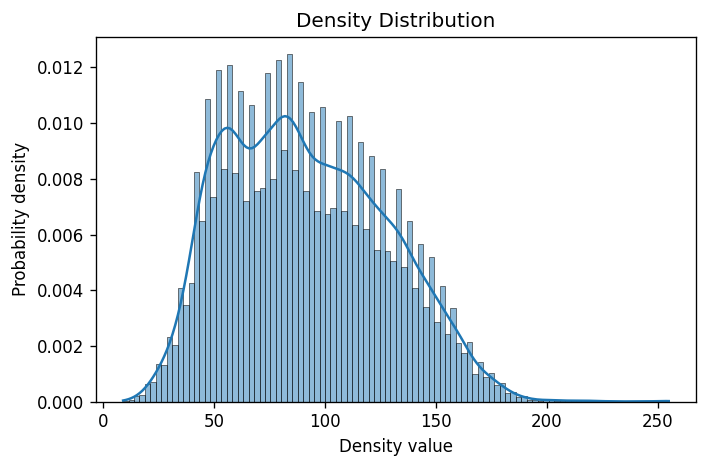

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Load density image (PNG)
density = np.array(Image.open("/mnt/data1tb/vinh/ISSM-SAR/dataset/trash/5b254521-572e-488e-a371-9ea8f5dcf80e.png")).astype(float)
values = density.flatten()

plt.figure(figsize=(6, 4))
sns.histplot(
    values,
    bins=100,
    stat="density",   # 👈 Y là density
    kde=True
)

plt.xlabel("Density value")
plt.ylabel("Probability density")
plt.title("Density Distribution")
plt.tight_layout()
plt.show()
